<a href="https://colab.research.google.com/github/parekhakhil/pyImageSearch/blob/main/1501_classifier_to_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

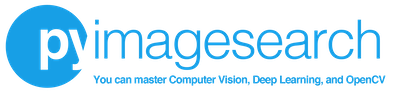

# Turning any CNN image classifier into an object detector with Keras, TensorFlow, and OpenCV
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch Plus](http://pyimg.co/plus)** Jupyter Notebooks!

This notebook is associated with the [Turning any CNN image classifier into an object detector with Keras, TensorFlow, and OpenCV](https://www.pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/) blog post published on 2020-06-22.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch Plus Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2020 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch Plus at http://pyimg.co/plus/ today.*

### Install the necessary packages

In [ ]:
!pip install tensorflow==2.2.0

### Download the code zip file

In [ ]:
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/classifier-to-detector/classifier-to-detector.zip
!unzip -qq classifier-to-detector.zip
%cd classifier-to-detector

## Blog Post Code

### Import Packages

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
from pyimagesearch.detection_helpers import sliding_window
from pyimagesearch.detection_helpers import image_pyramid
from matplotlib import pyplot as plt
import numpy as np
import argparse
import imutils
import time
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [ ]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementing our image pyramid and sliding window utility functions

In [ ]:
def sliding_window(image, step, ws):
	# slide a window across the image
	for y in range(0, image.shape[0] - ws[1], step):
		for x in range(0, image.shape[1] - ws[0], step):
			# yield the current window
			yield (x, y, image[y:y + ws[1], x:x + ws[0]])

In [ ]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
	# yield the original image
	yield image

	# keep looping over the image pyramid
	while True:
		# compute the dimensions of the next image in the pyramid
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)

		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break

		# yield the next image in the pyramid
		yield image

### Using Keras and TensorFlow to turn a pre-trained image classifier into an object detector

In [ ]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True,
#	help="path to the input image")
#ap.add_argument("-s", "--size", type=str, default="(200, 150)",
#	help="ROI size (in pixels)")
#ap.add_argument("-c", "--min-conf", type=float, default=0.9,
#	help="minimum probability to filter weak detections")
#ap.add_argument("-v", "--visualize", type=int, default=-1,
#	help="whether or not to show extra visualizations for debugging")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "images/stingray.jpg",
	"size": "(300, 150)",
	"min_conf": 0.9,
	"visualize": -1
}

In [ ]:
# initialize variables used for the object detection procedure
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = eval(args["size"])
INPUT_SIZE = (224, 224)

In [ ]:
# load our network weights from disk
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top=True)

# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
orig = cv2.imread(args["image"])
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

In [ ]:
# initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)

# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []

# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

In [ ]:
# loop over the image pyramid
for image in pyramid:
	# determine the scale factor between the *original* image
	# dimensions and the *current* layer of the pyramid
	scale = W / float(image.shape[1])

	# for each layer of the image pyramid, loop over the sliding
	# window locations
	for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
		# scale the (x, y)-coordinates of the ROI with respect to the
		# *original* image dimensions
		x = int(x * scale)
		y = int(y * scale)
		w = int(ROI_SIZE[0] * scale)
		h = int(ROI_SIZE[1] * scale)

		# take the ROI and preprocess it so we can later classify
		# the region using Keras/TensorFlow
		roi = cv2.resize(roiOrig, INPUT_SIZE)
		roi = img_to_array(roi)
		roi = preprocess_input(roi)

		# update our list of ROIs and associated coordinates
		rois.append(roi)
		locs.append((x, y, x + w, y + h))

        # check to see if we are visualizing each of the sliding
		# windows in the image pyramid
		if args["visualize"] > 0:
			# clone the original image and then draw a bounding box
			# surrounding the current region
			clone = orig.copy()
			cv2.rectangle(clone, (x, y), (x + w, y + h),
				(0, 255, 0), 2)

			# show the visualization and current ROI
			plt_imshow("Visualization", clone)
			plt_imshow("ROI", roiOrig)

In [ ]:
# show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
	end - start))

# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")

# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(
	end - start))

# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)
preds = imagenet_utils.decode_predictions(preds, top=1)
labels = {}

In [ ]:
# loop over the predictions
for (i, p) in enumerate(preds):
	# grab the prediction information for the current ROI
	(imagenetID, label, prob) = p[0]

	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
	if prob >= args["min_conf"]:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
		box = locs[i]

		# grab the list of predictions for the label and add the
		# bounding box and probability to the list
		L = labels.get(label, [])
		L.append((box, prob))
		labels[label] = L

In [ ]:
# loop over the labels for each of detected objects in the image
for label in labels.keys():
	# clone the original image so that we can draw on it
	print("[INFO] showing results for '{}'".format(label))
	clone = orig.copy()

	# loop over all bounding boxes for the current label
	for (box, prob) in labels[label]:
		# draw the bounding box on the image
		(startX, startY, endX, endY) = box
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)

	# show the results *before* applying non-maxima suppression, then
	# clone the image again so we can display the results *after*
	# applying non-maxima suppression
	plt_imshow("Before", clone)
	clone = orig.copy()

    # extract the bounding boxes and associated prediction
	# probabilities, then apply non-maxima suppression
	boxes = np.array([p[0] for p in labels[label]])
	proba = np.array([p[1] for p in labels[label]])
	boxes = non_max_suppression(boxes, proba)

	# loop over all bounding boxes that were kept after applying
	# non-maxima suppression
	for (startX, startY, endX, endY) in boxes:
		# draw the bounding box and label on the image
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.putText(clone, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

	# show the output after apply non-maxima suppression
	plt_imshow("After", clone)

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Turning any CNN image classifier into an object detector with Keras, TensorFlow, and OpenCV*](https://www.pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/) published on 2020-06-22.

# Code License Agreement
```
Copyright (c) 2020 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```